In [121]:
"""Multi Layer NN
src code @ https://github.com/Audhil/tensorflow_cookbook/blob/master/06_Neural_Networks/06_Using_Multiple_Layers/06_using_a_multiple_layer_network.ipynb"""

import tensorflow as tf
import numpy as np
import os
import requests
import csv
import matplotlib.pyplot as plt

In [122]:
# Low Birth Rate Data
# Columns    Variable                                      Abbreviation
# ---------------------------------------------------------------------
# Low Birth Weight (0 = Birth Weight >= 2500g,            LOW
#                          1 = Birth Weight < 2500g)
# Age of the Mother in Years                              AGE
# Weight in Pounds at the Last Menstrual Period           LWT
# Race (1 = White, 2 = Black, 3 = Other)                  RACE
# Smoking Status During Pregnancy (1 = Yes, 0 = No)       SMOKE
# History of Premature Labor (0 = None  1 = One, etc.)    PTL
# History of Hypertension (1 = Yes, 0 = No)               HT
# Presence of Uterine Irritability (1 = Yes, 0 = No)      UI
# Birth Weight in Grams                                   BWT
# ---------------------------------------------------------------------

In [123]:
# Preprocess data
birth_weight_file = 'birth_weight.csv'

# making a file if not exists
if not os.path.exists(birth_weight_file):
    birth_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birth_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x) >= 1] for y in birth_data[1:] if len(y) >= 1]
    with open(birth_weight_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerows([birth_header])
        writer.writerows(birth_data)
        f.close()

# read the file to memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

# making everything to flow
birth_data = [[float(x) for x in row] for row in birth_data]

# y_targets
y_vals = np.array([x[8] for x in birth_data])

# Filter for features of interest
cols_of_interest = ['AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI']
x_vals = np.array(
    [[x[ix] for ix, feature in enumerate(birth_header) if feature in cols_of_interest] for x in birth_data])

Generation: 25. Loss = 2931.2
Generation: 50. Loss = 2903.17
Generation: 75. Loss = 2883.2
Generation: 100. Loss = 3014.9
Generation: 125. Loss = 2876.4
Generation: 150. Loss = 2890.29
Generation: 175. Loss = 2950.65
Generation: 200. Loss = 3062.05

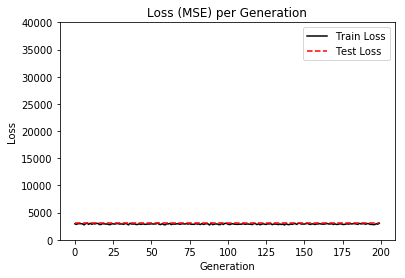

In [124]:
# Train the model
# tuning knobs
batch_size = 100
learning_rate = .05

# make results reproducible
seed = 3
np.random.seed(seed)
tf.set_random_seed(seed)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]


# Normalize by column (min-max norm to be between 0 and 1)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)


x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))


# Define Variable Functions (weights and bias)
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return weight


def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return bias


# Create Placeholders
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)


# Create a fully connected layer:
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return tf.nn.relu(layer)


# --------Create the first layer (50 hidden nodes)--------
weight_1 = init_weight(shape=[7, 25], st_dev=10.0)
bias_1 = init_bias(shape=[25], st_dev=10.0)
layer_1 = fully_connected(x_data, weight_1, bias_1)

# --------Create the second layer (25 hidden nodes)--------
weight_2 = init_weight(shape=[25, 10], st_dev=10.0)
bias_2 = init_bias(shape=[10], st_dev=10.0)
layer_2 = fully_connected(layer_1, weight_2, bias_2)

# --------Create third layer (5 hidden nodes)--------
weight_3 = init_weight(shape=[10, 3], st_dev=10.0)
bias_3 = init_bias(shape=[3], st_dev=10.0)
layer_3 = fully_connected(layer_2, weight_3, bias_3)

# --------Create output layer (1 output value)--------
weight_4 = init_weight(shape=[3, 1], st_dev=10.0)
bias_4 = init_bias(shape=[1], st_dev=10.0)
final_output = fully_connected(layer_3, weight_4, bias_4)

# L1 loss function
loss = tf.reduce_mean(tf.abs(final_output - y_target))

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

init_vars = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_vars)
    loss_vec = []
    test_loss = []
    for i in range(200):
        rand_index = np.random.choice(len(x_vals_train), size=batch_size)
        rand_x = x_vals_train[rand_index]
        rand_y = np.transpose([y_vals_train[rand_index]])
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        loss_vec.append(temp_loss)
        test_temp_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
        test_loss.append(test_temp_loss)
        if (i + 1) % 25 == 0:
            print('Generation: ' + str(i + 1) + '. Loss = ' + str(temp_loss))

    % matplotlib inline
    # Plot loss (MSE) over time
    plt.plot(loss_vec, 'k-', label='Train Loss')
    plt.plot(test_loss, 'r--', label='Test Loss')
    plt.title('Loss (MSE) per Generation')
    plt.legend(loc='upper right')
    plt.xlabel('Generation')
    plt.ylabel('Loss')
    plt.ylim(0, 40000)
    plt.show()
